# **Proyek 3: Image Classification and Deployment**

### Nico Marcelino

In [1]:
# install package and upload API key
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"helixneek","key":"dcfc8fada4acacb6f21efd5d5de301be"}'}

In [2]:
# change permissions and make directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
# download and unzip file
!kaggle datasets download -d vencerlanz09/bottle-synthetic-images-dataset

!mkdir bottle-synthetic-images-dataset.zip
!unzip bottle-synthetic-images-dataset.zip -d bottle-synthetic-images-dataset
!ls bottle-synthetic-images-dataset

Streaming output truncated to the last 5000 lines.
  inflating: bottle-synthetic-images-dataset/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010002.jpg  
  inflating: bottle-synthetic-images-dataset/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010003.jpg  
  inflating: bottle-synthetic-images-dataset/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010004.jpg  
  inflating: bottle-synthetic-images-dataset/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010005.jpg  
  inflating: bottle-synthetic-images-dataset/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010006.jpg  
  inflating: bottle-synthetic-images-dataset/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010007.jpg  
  inflating: bottle-synthetic-images-dataset/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010008.jpg  
  inflating: bottle-synthetic-images-dataset/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010009.jpg  
  inflating: bottle-synthetic-images-dataset/ImageClassesComb

In [4]:
# import libraries
import numpy as np
import pandas as pd
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [5]:
!pip install split-folders
import splitfolders

!rm -rf ../content/bottle-synthetic-images-dataset/Bottle Images/Bottle Images

splitfolders.ratio("../content/bottle-synthetic-images-dataset/Bottle Images/Bottle Images", 
    output="../content/bottle-synthetic-images-dataset/Bottle Images/Split Images",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 25000 files [00:04, 5610.14 files/s]


In [18]:
base_dir = '/content/bottle-synthetic-images-dataset/Bottle Images/Split Images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [19]:
os.listdir('/content/bottle-synthetic-images-dataset/Bottle Images/Split Images/train')

['Water Bottle',
 'Wine Bottle',
 'Soda Bottle',
 'Plastic Bottles',
 'Beer Bottles']

In [20]:
os.listdir('/content/bottle-synthetic-images-dataset/Bottle Images/Split Images/val')

['Water Bottle',
 'Wine Bottle',
 'Soda Bottle',
 'Plastic Bottles',
 'Beer Bottles']

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 20,
                    horizontal_flip = True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 20,
                    horizontal_flip = True,
                    vertical_flip = True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [22]:
train_generator = train_datagen.flow_from_directory(
    train_dir, # directory data train
    target_size = (150, 150),
    batch_size = 50,
    class_mode = 'categorical',
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir, # directory data test
    target_size = (150, 150),
    batch_size = 50,
    class_mode = 'categorical',
)

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [23]:
# callback function
# cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, min_delta=0.2, restore_best_weights=True)
class earlystop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    if((logs.get('accuracy') > 0.92) and (logs.get('val_accuracy') > 0.92)):
      print("Accuracy has reached over 92%!")
      self.model.stop_training = True

callbacks = earlystop()

In [24]:
# membuat convolutional neural network    
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [25]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [26]:
# latih model dengan model.fit
history = model.fit(
    train_generator,
    steps_per_epoch = 40, # berapa batch yg akan di-execute per epoch
    epochs = 50, # ditambah jika model belum optimal
    validation_data = validation_generator, # menampilkan accuracy tes data validasi
    validation_steps = 30, # berapa batch yg akan di-execute per epoch
    verbose = 2,
    callbacks = [callbacks]
)

Epoch 1/50
40/40 - 92s - loss: 1.5271 - accuracy: 0.2900 - val_loss: 1.4233 - val_accuracy: 0.3513 - 92s/epoch - 2s/step
Epoch 2/50
40/40 - 90s - loss: 1.3757 - accuracy: 0.3875 - val_loss: 1.2988 - val_accuracy: 0.4447 - 90s/epoch - 2s/step
Epoch 3/50
40/40 - 91s - loss: 1.3097 - accuracy: 0.4180 - val_loss: 1.3092 - val_accuracy: 0.4507 - 91s/epoch - 2s/step
Epoch 4/50
40/40 - 102s - loss: 1.2174 - accuracy: 0.4755 - val_loss: 1.0878 - val_accuracy: 0.5393 - 102s/epoch - 3s/step
Epoch 5/50
40/40 - 91s - loss: 1.0438 - accuracy: 0.5740 - val_loss: 0.9887 - val_accuracy: 0.6027 - 91s/epoch - 2s/step
Epoch 6/50
40/40 - 91s - loss: 0.9846 - accuracy: 0.6100 - val_loss: 1.0985 - val_accuracy: 0.5760 - 91s/epoch - 2s/step
Epoch 7/50
40/40 - 90s - loss: 0.8667 - accuracy: 0.6730 - val_loss: 0.7947 - val_accuracy: 0.7020 - 90s/epoch - 2s/step
Epoch 8/50
40/40 - 90s - loss: 0.7338 - accuracy: 0.7215 - val_loss: 0.6851 - val_accuracy: 0.7520 - 90s/epoch - 2s/step
Epoch 9/50
40/40 - 90s - loss:

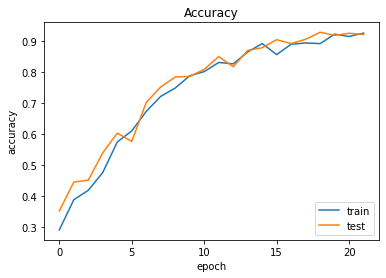

In [29]:
# plot of accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

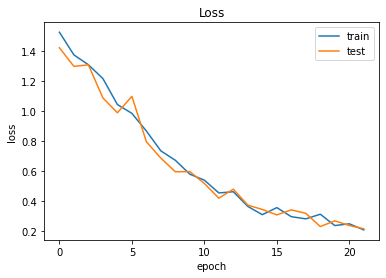

In [28]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [32]:
import pathlib

# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
     
# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
     
tflite_model_file = pathlib.Path('bottle.tflite')
tflite_model_file.write_bytes(tflite_model)

13825484